In [ ]:
#####################
#     VT Ploting    #
#####################
#  yliu301@iit.edu  #
#####################
#   plotvtm.ipynb   #
#    Version 0.5    #
#####################

In [65]:
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import time
import operator

In [58]:
def matchDate(line):
    matchThis = ""
    matched = re.match(r'\d\d\d\d-\d\d-\d\d\ \d\d:\d\d:\d\d',line)
    if matched:
        #matches a date and adds it to matchThis            
        matchThis = matched.group() 
    else:
        matchThis = "NONE"
    return matchThis


def generateDicts(log_fh):
    """
    Arg:
    log_fh...file
    Return:
    currentDict..dict
    """
    currentDict = {}
    for line in log_fh:
        if line.startswith(matchDate(line)):
            if currentDict:
                yield currentDict
            currentDict = {"date":line.split("__")[0][:23],"type":line.split("-",5)[3],"text":line.split("-",5)[-1].rstrip()}
        else:
            currentDict["text"] += line
    yield currentDict


vtmfiles = ['vmgm_80.log', 'vmgm_189.log'] # Put vtmg files
list_parsed_files = []
for i, f in enumerate(vtmfiles):
    with open(f) as f:
        listNew= list(generateDicts(f)) # list contains dict
        print f
        print listNew[0] # Start date
        print listNew[1] # Start Connection Manager
        print listNew[2] # Start Host Activities
    list_parsed_files.append(listNew)

<open file 'vmgm_80.log', mode 'r' at 0x1075ebed0>
{'date': '2018-03-19 12:23:00,941', 'text': ' Starting Service ID: #2', 'type': ' root '}
{'date': '2018-03-19 12:23:00,951', 'text': ' Connection Manager Started: 1521480180.950768948', 'type': ' root '}
{'date': '2018-03-19 12:23:00,960', 'text': ' Host Activities Started: 1521480180.959573984', 'type': ' root '}
<open file 'vmgm_189.log', mode 'r' at 0x1075ebed0>
{'date': '2018-03-19 12:23:00,813', 'text': ' Starting Service ID: #1', 'type': ' root '}
{'date': '2018-03-19 12:23:00,824', 'text': ' Connection Manager Started: 1521480180.822966099', 'type': ' root '}
{'date': '2018-03-19 12:23:00,832', 'text': ' Host Activities Started: 1521480180.831728935', 'type': ' root '}


In [59]:
_datetime_format = "%Y-%m-%d %H:%M:%S"
_dmesg_line_regex = re.compile("^\[\s*(?P<time>\d+\.\d+)\](?P<line>.*)$")
dmgfiles = ['dmesg_80.log', 'dmesg_189.log']

list_dmgFiles = [] # list in list

for i, f in enumerate(dmgfiles):
    with open(f) as dmesg_data:
        list_parsedMsg = []
        for line in dmesg_data:
            if not line:
                continue
            match = _dmesg_line_regex.match(line)
            if match:
                try:
                    # seconds = int(match.groupdict().get('time', '').split('.')[0])
                    #nanoseconds = int(match.groupdict().get('time', '').split('.')[1])
                    # microseconds = int(round(nanoseconds * 0.001))
                    line = match.groupdict().get('line', '')
                    list_parsedMsg.append(line.split())
                    # t = timedelta(seconds=seconds, microseconds=microseconds)
                except IndexError:
                    pass
        
        list_dmgFiles.append(list_parsedMsg)
print "Sample (First file first line): ", list_dmgFiles[0][0]

Sample (First file first line):  ['VT-GPIO_TEST:', 'Initializing', 'the', 'Virtual', 'Time', 'GPIO_TEST', 'LKM']


Pi_ 1 : 
Start time for NetCoor:  1521480180.950768948
Start time for HostAct:  1521480180.959573984
Pi_ 2 : 
Start time for NetCoor:  1521480180.822966099
Start time for HostAct:  1521480180.831728935


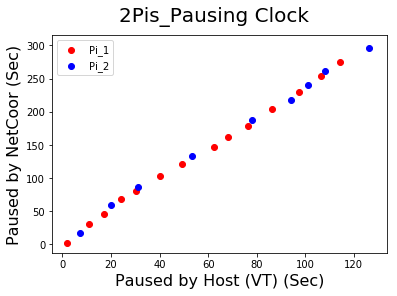

In [60]:
# Graph of pause by NC and HA: Pause time - start time
colors = ['r', 'b', 'g', 'k', 'm']
fig = plt.figure()
fig.suptitle(str(len(list_parsed_files)) +'Pis_Pausing Clock', fontsize=20)
axis = plt.gca().xaxis
leg_list = []

for i, fd in enumerate(list_parsed_files):
    start_time_NC = fd[1]["text"].split(': ')[1]
    start_time_HA = fd[2]["text"].split(': ')[1]
    print 'Pi_', i+1,': '
    print 'Start time for NetCoor: ', start_time_NC
    print 'Start time for HostAct: ', start_time_HA
    
    x = [float(item["text"].split()[1]) - float(start_time_HA) for item in fd[3:] if item["text"].split()[0] == "Host_System_pasuing:"]
    y = [float(item["text"].split()[1]) - float(start_time_NC) for item in fd[3:] if item["text"].split()[0] == "NCProcHandler_Stop_Services:"]
    leg_list.append('Pi_'+str(i+1))
    plt.scatter(x,y, color=colors[i])

#for label in axis.get_ticklabels():
#    label.set_rotation(90)
plt.xlabel('Paused by Host (VT) (Sec)', fontsize=16)
plt.ylabel('Paused by NetCoor (Sec)', fontsize=16)
plt.legend(leg_list)
plt.show()

Pi_ 1 : 
Start time for NetCoor:  1521480180.950768948
Start time for HostAct:  1521480180.959573984
Pi_ 2 : 
Start time for NetCoor:  1521480180.822966099
Start time for HostAct:  1521480180.831728935


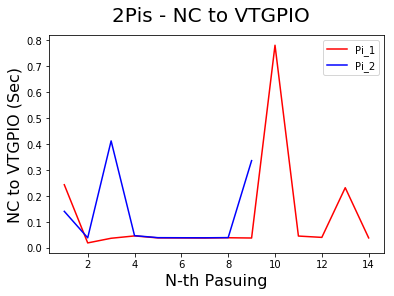

In [64]:
# Graph of pause by NC to VTGPIO: Pause time
fig = plt.figure()
fig.suptitle(str(len(list_parsed_files)) +'Pis - NC to VTGPIO', fontsize=20)
axis = plt.gca().xaxis
leg_list = []
for i, fd in enumerate(list_parsed_files):
    start_time_NC = fd[1]["text"].split(': ')[1]
    start_time_HA = fd[2]["text"].split(': ')[1]
    print 'Pi_', i+1,': '
    print 'Start time for NetCoor: ', start_time_NC
    print 'Start time for HostAct: ', start_time_HA
    
    x = [float(item["text"].split()[1]) for item in fd[3:] if item["text"].split()[0] == "NCProcHandler_Stop_Services:"]
    y = []
    for i2, item in enumerate(list_dmgFiles[i]):
        if list_dmgFiles[i][i2-1][-1] == 'pause':
            y.append(float(item[-3] + '.' + item[-2]))

    y2 = map(operator.sub, y, x)    
    x2 = [ind+1 for ind in range(len(y))]
    leg_list.append('Pi_'+str(i+1))
    plt.plot(x2, y2, color=colors[i])
    
plt.xlabel('N-th Pasuing', fontsize=16)
plt.ylabel('NC to VTGPIO (Sec)', fontsize=16)
plt.legend(leg_list)
plt.show()